In [1]:
import os, shutil
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

C:\Users\valer\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\valer\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\valer\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\valer\Anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dty

# Chapter 3

## Logistic Regression

In [2]:
def inference(x):
    init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", [784, 10],
                         initializer=init)
    b = tf.get_variable("b", [10],
                         initializer=init)
    output = tf.nn.softmax(tf.matmul(x, W) + b)

    w_hist = tf.summary.histogram("weights", W)
    b_hist = tf.summary.histogram("biases", b)
    y_hist = tf.summary.histogram("output", output)

    return output

In [3]:
def loss(output, y):
    dot_product = y * tf.log(output)

    # Reduction along axis 0 collapses each column into a single
    # value, whereas reduction along axis 1 collapses each row 
    # into a single value. In general, reduction along axis i 
    # collapses the ith dimension of a tensor to size 1.
    xentropy = -tf.reduce_sum(dot_product, axis=1)
     
    loss = tf.reduce_mean(xentropy)

    return loss

## Multi Layer Perceptron

In [2]:
def layer(input, weight_shape, bias_shape):
    weight_stddev = (2.0/weight_shape[0])**0.5
    w_init = tf.random_normal_initializer(stddev=weight_stddev)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=w_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    
    return tf.nn.relu(tf.matmul(input, W) + b)

In [3]:
def inference(x):
    with tf.variable_scope("hidden_1"):
        hidden_1 = layer(x, [784, 256], [256])
    with tf.variable_scope("hidden_2"):
        hidden_2 = layer(hidden_1, [256, 256], [256])
    with tf.variable_scope("output"):
        output = layer(hidden_2, [256, 10], [10])
        
    return output

In [4]:
def loss(output, y):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y)
    loss = tf.reduce_mean(xentropy)
    
    return loss

## Training

In [5]:
def training(cost, global_step):
    tf.summary.scalar("cost", cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(cost, global_step=global_step)

    return train_op

In [6]:
def evaluate(output, y):
    correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tf.summary.scalar("validation error", (1.0 - accuracy))

    return accuracy

In [7]:
from fdl_examples.datatools import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [10]:
#Parameters
learning_rate = 0.01
training_epochs = 300 # 1000
batch_size = 100
display_step = 1

if os.path.exists("logistic_logs/"):
    shutil.rmtree("logistic_logs/")

with tf.Graph().as_default():
    
    x = tf.placeholder("float", [None, 784]) # mnist data image of shape 28*28=784
    y = tf.placeholder("float", [None, 10]) # 0-9 digits recognition => 10 classes


    output = inference(x)

    cost = loss(output, y)

    global_step = tf.Variable(0, name='global_step', trainable=False)

    train_op = training(cost, global_step)

    eval_op = evaluate(output, y)

    summary_op = tf.summary.merge_all()

    saver = tf.train.Saver()

    sess = tf.Session()

    summary_writer = tf.summary.FileWriter("logistic_logs/",
                                        graph_def=sess.graph_def)

        
    init_op = tf.global_variables_initializer()

    sess.run(init_op)


    # Training cycle
    for epoch in range(training_epochs):

        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            minibatch_x, minibatch_y = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            sess.run(train_op, feed_dict={x: minibatch_x, y: minibatch_y})
            # Compute average loss
            avg_cost += sess.run(cost, feed_dict={x: minibatch_x, y: minibatch_y})/total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost))

            accuracy = sess.run(eval_op, feed_dict={x: mnist.validation.images, y: mnist.validation.labels})

            print("Validation Error:", (1 - accuracy))

            summary_str = sess.run(summary_op, feed_dict={x: minibatch_x, y: minibatch_y})
            summary_writer.add_summary(summary_str, sess.run(global_step))

            saver.save(sess, "logistic_logs/model-checkpoint", global_step=global_step)


    print("Optimization Finished!")


    accuracy = sess.run(eval_op, feed_dict={x: mnist.test.images, y: mnist.test.labels})

    print("Test Accuracy:", accuracy)

INFO:tensorflow:Summary name validation error is illegal; using validation_error instead.
Epoch: 0001 cost = 1.310103764
Validation Error: 0.22100001573562622
Epoch: 0002 cost = 0.554166041
Validation Error: 0.09880000352859497
Epoch: 0003 cost = 0.335758060
Validation Error: 0.08319997787475586
Epoch: 0004 cost = 0.290809048
Validation Error: 0.07260000705718994
Epoch: 0005 cost = 0.263471516
Validation Error: 0.06699997186660767
Epoch: 0006 cost = 0.243398041
Validation Error: 0.06440001726150513
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch: 0007 cost = 0.226765114
Validation Error: 0.06300002336502075
Epoch: 0008 cost = 0.212554853
Validation Error: 0.05760002136230469
Epoch: 0009 cost = 0.200242613
Validation Error: 0.05540001392364502
Epoch: 0010 cost = 0.189484788
Validation Error: 0.052799999713897705
Epoch: 0011 cost = 0.179869927
Validation Error: 0.0504000186920166
Epoch: 0012 cost = 0.171149287
Validation Error: 0.0496000051498413

Epoch: 0112 cost = 0.016729500
Validation Error: 0.019800007343292236
Epoch: 0113 cost = 0.016435145
Validation Error: 0.01940000057220459
Epoch: 0114 cost = 0.016187514
Validation Error: 0.019599974155426025
Epoch: 0115 cost = 0.015913412
Validation Error: 0.02039998769760132
Epoch: 0116 cost = 0.015686491
Validation Error: 0.020200014114379883
Epoch: 0117 cost = 0.015463967
Validation Error: 0.019599974155426025
Epoch: 0118 cost = 0.015193136
Validation Error: 0.019800007343292236
Epoch: 0119 cost = 0.014987176
Validation Error: 0.02039998769760132
Epoch: 0120 cost = 0.014787059
Validation Error: 0.019800007343292236
Epoch: 0121 cost = 0.014544529
Validation Error: 0.020200014114379883
Epoch: 0122 cost = 0.014307849
Validation Error: 0.020200014114379883
Epoch: 0123 cost = 0.014085519
Validation Error: 0.019800007343292236
Epoch: 0124 cost = 0.013864144
Validation Error: 0.019800007343292236
Epoch: 0125 cost = 0.013705885
Validation Error: 0.02060002088546753
Epoch: 0126 cost = 0.013

Epoch: 0230 cost = 0.004476253
Validation Error: 0.01819998025894165
Epoch: 0231 cost = 0.004437144
Validation Error: 0.01819998025894165
Epoch: 0232 cost = 0.004402730
Validation Error: 0.01819998025894165
Epoch: 0233 cost = 0.004360411
Validation Error: 0.01819998025894165
Epoch: 0234 cost = 0.004343804
Validation Error: 0.018000006675720215
Epoch: 0235 cost = 0.004318340
Validation Error: 0.018000006675720215
Epoch: 0236 cost = 0.004279967
Validation Error: 0.018599987030029297
Epoch: 0237 cost = 0.004250684
Validation Error: 0.018000006675720215
Epoch: 0238 cost = 0.004211042
Validation Error: 0.018000006675720215
Epoch: 0239 cost = 0.004181298
Validation Error: 0.01819998025894165
Epoch: 0240 cost = 0.004154748
Validation Error: 0.018000006675720215
Epoch: 0241 cost = 0.004127605
Validation Error: 0.018000006675720215
Epoch: 0242 cost = 0.004095654
Validation Error: 0.01819998025894165
Epoch: 0243 cost = 0.004067403
Validation Error: 0.018800020217895508
Epoch: 0244 cost = 0.00404

Epoch: 0348 cost = 0.002248901
Validation Error: 0.01819998025894165
Epoch: 0349 cost = 0.002240240
Validation Error: 0.018800020217895508
Epoch: 0350 cost = 0.002229691
Validation Error: 0.01819998025894165
Epoch: 0351 cost = 0.002216737
Validation Error: 0.018599987030029297
Epoch: 0352 cost = 0.002210560
Validation Error: 0.01840001344680786
Epoch: 0353 cost = 0.002197933
Validation Error: 0.01819998025894165
Epoch: 0354 cost = 0.002189182
Validation Error: 0.01840001344680786
Epoch: 0355 cost = 0.002181772
Validation Error: 0.018599987030029297
Epoch: 0356 cost = 0.002171457
Validation Error: 0.018599987030029297
Epoch: 0357 cost = 0.002158740
Validation Error: 0.01840001344680786
Epoch: 0358 cost = 0.002151011
Validation Error: 0.01819998025894165
Epoch: 0359 cost = 0.002140750
Validation Error: 0.018599987030029297
Epoch: 0360 cost = 0.002128916
Validation Error: 0.01840001344680786
Epoch: 0361 cost = 0.002121991
Validation Error: 0.018800020217895508
Epoch: 0362 cost = 0.0021118

Epoch: 0466 cost = 0.001409676
Validation Error: 0.018000006675720215
Epoch: 0467 cost = 0.001405275
Validation Error: 0.018599987030029297
Epoch: 0468 cost = 0.001400852
Validation Error: 0.01819998025894165
Epoch: 0469 cost = 0.001396262
Validation Error: 0.01840001344680786
Epoch: 0470 cost = 0.001392213
Validation Error: 0.018599987030029297
Epoch: 0471 cost = 0.001386068
Validation Error: 0.018599987030029297
Epoch: 0472 cost = 0.001381875
Validation Error: 0.01819998025894165
Epoch: 0473 cost = 0.001377328
Validation Error: 0.01840001344680786
Epoch: 0474 cost = 0.001373303
Validation Error: 0.01819998025894165
Epoch: 0475 cost = 0.001368784
Validation Error: 0.01819998025894165
Epoch: 0476 cost = 0.001363269
Validation Error: 0.018599987030029297
Epoch: 0477 cost = 0.001360691
Validation Error: 0.01819998025894165
Epoch: 0478 cost = 0.001355580
Validation Error: 0.01819998025894165
Epoch: 0479 cost = 0.001350793
Validation Error: 0.01819998025894165
Epoch: 0480 cost = 0.00134715

Epoch: 0585 cost = 0.001011717
Validation Error: 0.01840001344680786
Epoch: 0586 cost = 0.001009268
Validation Error: 0.01840001344680786
Epoch: 0587 cost = 0.001007012
Validation Error: 0.018599987030029297
Epoch: 0588 cost = 0.001003322
Validation Error: 0.018599987030029297
Epoch: 0589 cost = 0.001003009
Validation Error: 0.01819998025894165
Epoch: 0590 cost = 0.001000717
Validation Error: 0.01840001344680786
Epoch: 0591 cost = 0.000997658
Validation Error: 0.01840001344680786
Epoch: 0592 cost = 0.000995688
Validation Error: 0.018599987030029297
Epoch: 0593 cost = 0.000992294
Validation Error: 0.018599987030029297
Epoch: 0594 cost = 0.000991210
Validation Error: 0.018800020217895508
Epoch: 0595 cost = 0.000988964
Validation Error: 0.01819998025894165
Epoch: 0596 cost = 0.000987169
Validation Error: 0.018599987030029297
Epoch: 0597 cost = 0.000983987
Validation Error: 0.018599987030029297
Epoch: 0598 cost = 0.000982355
Validation Error: 0.018599987030029297
Epoch: 0599 cost = 0.00098

Epoch: 0703 cost = 0.000763812
Validation Error: 0.018599987030029297
Epoch: 0704 cost = 0.000762035
Validation Error: 0.018599987030029297
Epoch: 0705 cost = 0.000760754
Validation Error: 0.018599987030029297
Epoch: 0706 cost = 0.000759009
Validation Error: 0.018599987030029297
Epoch: 0707 cost = 0.000757206
Validation Error: 0.018000006675720215
Epoch: 0708 cost = 0.000755926
Validation Error: 0.018599987030029297
Epoch: 0709 cost = 0.000754645
Validation Error: 0.018800020217895508
Epoch: 0710 cost = 0.000752972
Validation Error: 0.018800020217895508
Epoch: 0711 cost = 0.000751342
Validation Error: 0.018000006675720215
Epoch: 0712 cost = 0.000749847
Validation Error: 0.018800020217895508
Epoch: 0713 cost = 0.000749330
Validation Error: 0.01819998025894165
Epoch: 0714 cost = 0.000747306
Validation Error: 0.01819998025894165
Epoch: 0715 cost = 0.000746244
Validation Error: 0.01819998025894165
Epoch: 0716 cost = 0.000744989
Validation Error: 0.018800020217895508
Epoch: 0717 cost = 0.00

Epoch: 0821 cost = 0.000630211
Validation Error: 0.01840001344680786
Epoch: 0822 cost = 0.000629139
Validation Error: 0.01840001344680786
Epoch: 0823 cost = 0.000628316
Validation Error: 0.018800020217895508
Epoch: 0824 cost = 0.000627425
Validation Error: 0.01840001344680786
Epoch: 0825 cost = 0.000626508
Validation Error: 0.01840001344680786
Epoch: 0826 cost = 0.000625971
Validation Error: 0.018800020217895508
Epoch: 0827 cost = 0.000625089
Validation Error: 0.018599987030029297
Epoch: 0828 cost = 0.000623854
Validation Error: 0.018599987030029297
Epoch: 0829 cost = 0.000623121
Validation Error: 0.01819998025894165
Epoch: 0830 cost = 0.000622606
Validation Error: 0.01840001344680786
Epoch: 0831 cost = 0.000621356
Validation Error: 0.01840001344680786
Epoch: 0832 cost = 0.000620550
Validation Error: 0.018599987030029297
Epoch: 0833 cost = 0.000619815
Validation Error: 0.018599987030029297
Epoch: 0834 cost = 0.000618954
Validation Error: 0.018599987030029297
Epoch: 0835 cost = 0.000618

KeyboardInterrupt: 

# Chapter 4

## Linear Interpolation on Error Surface

In [ ]:
# TODO

# Chapter 5

## Momentum Based Optimization

In [ ]:
import random

In [ ]:
def plot_walk(walk, title):
    plt.plot(walk)
    plt.suptitle(title)
    plt.show()

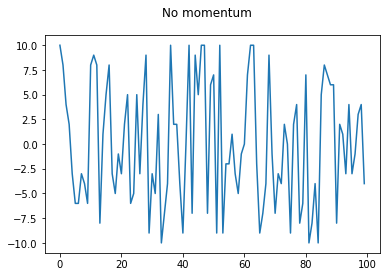

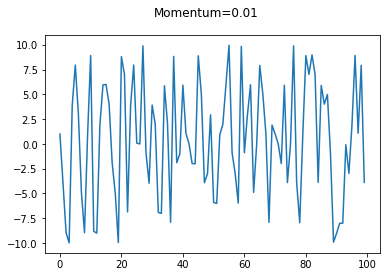

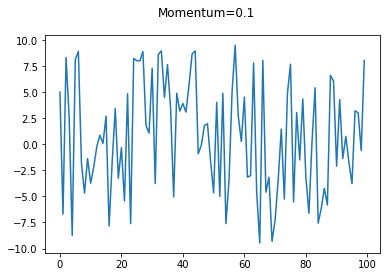

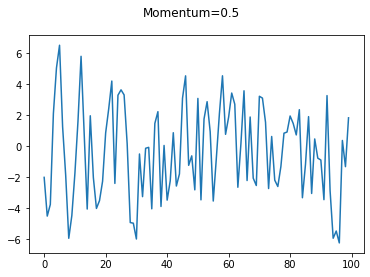

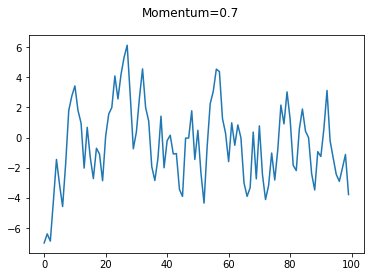

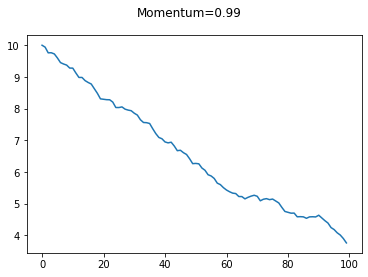

In [26]:
step_range = 10
step_choices = range(-1 * step_range, step_range + 1)
rand_walk = [random.choice(step_choices) for x in range(100)]
plot_walk(rand_walk, 'No momentum')

for momentum in [0.01, 0.1, 0.5, 0.7, 0.99]:
    momentum_rand_walk = [random.choice(step_choices)]
    for i in range(len(rand_walk) - 1):
        prev = momentum_rand_walk[-1]
        rand_choice = random.choice(step_choices)
        new_step = momentum * prev + (1 - momentum) * rand_choice
        momentum_rand_walk.append(new_step)
    plot_walk(momentum_rand_walk, 'Momentum=' + str(momentum))